References:
- [Probabilistic Programming & Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers?tab=readme-ov-file)
- [Statistical Rethinking 2023](https://github.com/dustinstansbury/statistical-rethinking-2023)
- [Danielle Navarro's Blog 'The Metropolis-Hastings algorithm'](https://blog.djnavarro.net/posts/2023-04-12_metropolis-hastings/#the-problem)
- [Martin Osvaldo A, Kumar Ravin; Lao Junpeng Bayesian Modeling and Computation in Python Boca Ratón, 2021. ISBN 978-0-367-89436-8](https://bayesiancomputationbook.com/welcome.html)



`pm.Exponential()` variables are treated by the back end as random number generators.

## Priors

### Prior Selection

The best way to choose priors depends on the context of the problem, your data, and your knowledge about the underlying system.

If prior information about the parameters exists (e.g., from prior studies, expert opinion, or physics-based reasoning), use it to inform the priors.

The [Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) page on Stan's wikipedia is a great overview of the topic. 

#### Weakly Informative Priors
When you lack strong prior knowledge but still want to impose reasonable regularization, weakly informative priors help constrain the model without dominating the posterior.

These priors are typically broad enough to allow for flexible learning from data but exclude extreme or implausible values.

#### Non-Informative Priors
Designed to have minimal influence on the posterior.

#### Empirical Bayes
Why not use the sampled score statistics to set priors? Priors should represent beliefs before observing the data. If we use priors from the data we get circular reasoning / data leakage.

### Commonly Used Priors
#### Beta Distribution
Used to model Bernoulli, Binomial, or Geometric distributions.

Bounded between [0,1]. 

$ Beta(1,1) $ is a uniform distribution. 

#### Gamma Distribution
Use Case: Rate parameters in Poisson or Exponential distributions; precision (inverse variance) in Normal distributions.

## Bayesian Bandits
An approximate solution to the infamous [Multi-Armed Bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit) can be found with Bayesian methods. In this example, we have 3 slot machines (bandits) that are win/lose for simplificiation and we don't know the probability of win/losing initially. We start with a $Beta(1,1)$ prior and sample from them to update our beliefs about which slot machine gives us the best chance of winning.

The code below samples every bandit each trail. In the real solution, only one bandit is sampled per trial. 

In [135]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# %config InlineBackend.figure_formats = ['svg']

plt.rcParams['figure.figsize'] = (12, 4)
rng = np.random.default_rng(seed=42)
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
n_simulations = 10000

slot_machine_1 = rng.binomial(n=1, p=0.3, size=n_simulations)
slot_machine_2 = rng.binomial(n=1, p=0.25, size=n_simulations)
slot_machine_3 = rng.binomial(n=1, p=0.1, size=n_simulations)
sim_list = [slot_machine_1, slot_machine_2, slot_machine_3]

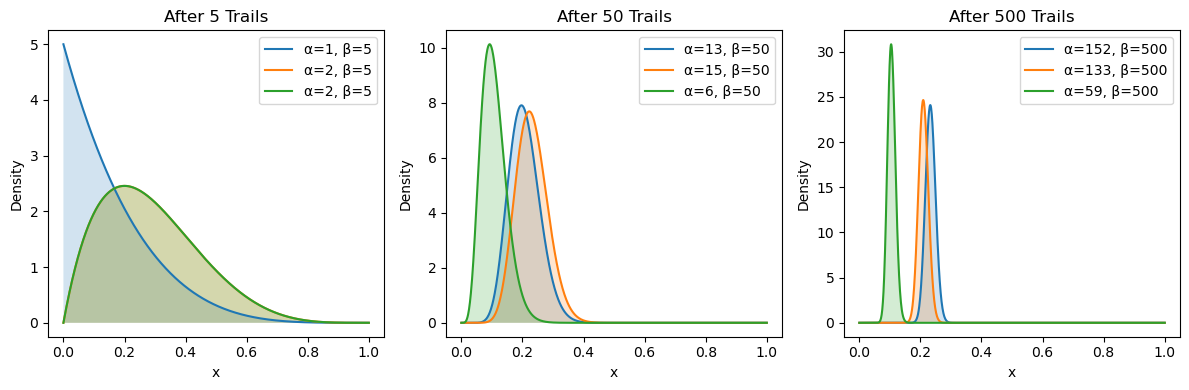

In [136]:
n_trials = [5, 50, 500]
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
x = np.linspace(0, 1, 1000)

for i, trails in enumerate(n_trials):
    for sim in sim_list:
        wins = rng.choice(sim, size=trails).sum()
        a = wins + 1
        b = trails
        y = stats.beta.pdf(x, a, b)
        axs[i].plot(x, y, label=f'α={a}, β={b}')
        axs[i].fill_between(x, y, alpha=0.2)
        axs[i].set_title(f'After {trails} Trails')
        axs[i].set_xlabel('x')
        axs[i].set_ylabel('Density')
        axs[i].legend()

plt.tight_layout()
plt.show()

## Detecting Change Over Time
We have data containing the count of events that occured on a given day. We want to determine if there has been an increase in events.

We start with the prior believe that the events are exponentially distributed with a mean that is equal to the observed data average. We also define a variable, $\tau$, that is uniformly distributed across each time step in the dataset. Then we sample from the observed data and update our believes and analyze the resulting distributions.  

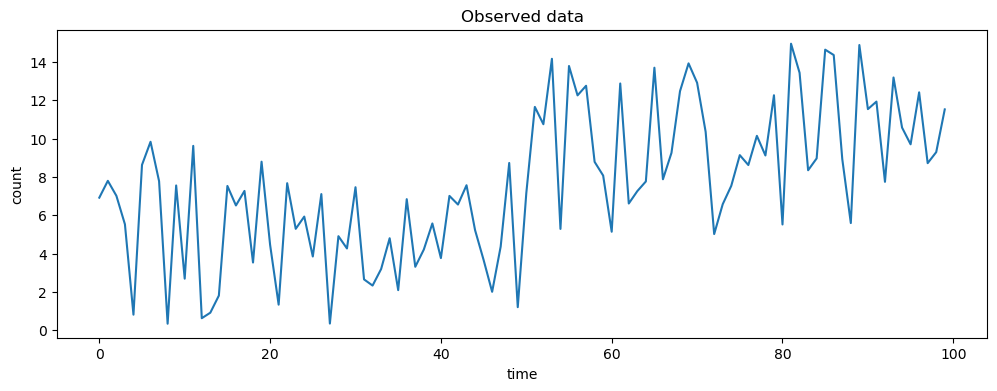

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 52 seconds.


In [137]:
data = np.concatenate([
    rng.uniform(low=0, high=10, size=50),
    rng.uniform(low=5, high=15, size=50)
])

n = len(data)
plt.plot(np.arange(n), data)
plt.title('Observed data')
plt.ylabel('count')
plt.xlabel('time')
plt.show()

with pm.Model() as model:
    alpha = 1.0 / data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)

    idx = np.arange(n)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=data)

    step = pm.NUTS()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

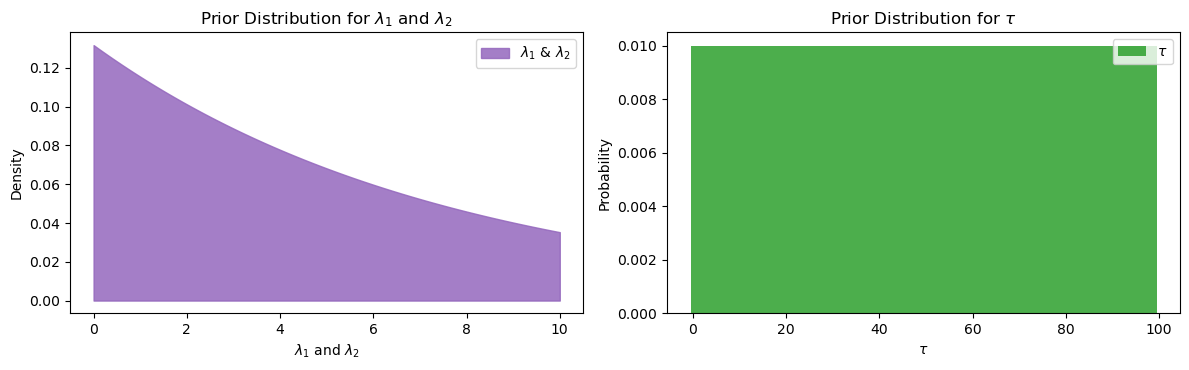

In [138]:
# Create a new figure for prior distributions
fig_prior, axes_prior = plt.subplots(1, 2)

x_values = np.linspace(0, 10, 100)
prior_lambda_1 = (alpha * np.exp(-alpha * x_values))  # Prior distribution for lambda_1
prior_lambda_2 = (alpha * np.exp(-alpha * x_values))  # Prior distribution for lambda_2

# Plot prior for lambda_1
axes_prior[0].fill_between(x_values, prior_lambda_1, color="C4", alpha=0.85, label='$\\lambda_1$ & $\\lambda_2$')
axes_prior[0].set_title("Prior Distribution for $\\lambda_1$ and $\\lambda_2$")
axes_prior[0].set_xlabel("$\\lambda_1$ and $\\lambda_2$")
axes_prior[0].legend(loc="upper right")
axes_prior[0].set_ylabel("Density")

# Plot prior for tau
tau_x_values = np.arange(0, n)  # Discrete values for tau
prior_tau = np.ones_like(tau_x_values) / len(tau_x_values)  # Uniform distribution
axes_prior[1].bar(tau_x_values, prior_tau, width=1, color="C2", alpha=0.85, label='$\\tau$')
axes_prior[1].set_title("Prior Distribution for $\\tau$")
axes_prior[1].set_xlabel("$\\tau$")
axes_prior[1].set_ylabel("Probability")
axes_prior[1].legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

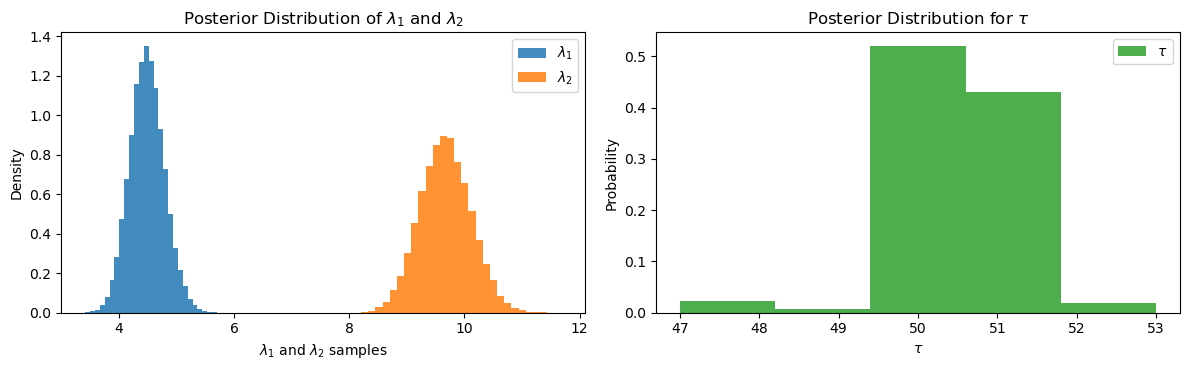

In [139]:
fig, axes = plt.subplots(1, 2)

axes[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85, color="C0", density=True, label='$\\lambda_1$')
axes[0].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85, color="C1", density=True, label='$\\lambda_2$')
axes[0].set_xlabel("$\\lambda_1$ and $\\lambda_2$ samples")
axes[0].set_ylabel("Density")
axes[0].legend(loc="upper right")
axes[0].set_title("Posterior Distribution of $\\lambda_1$ and $\\lambda_2$")

weights = np.ones_like(tau_samples) / tau_samples.shape[0]
axes[1].hist(tau_samples, bins=5, alpha=0.85, color="C2", weights=weights, label='$\\tau$')
axes[1].set_xlabel(r"$\tau$")
axes[1].set_ylabel("Probability")
axes[1].legend(loc="upper right")
axes[1].set_title("Posterior Distribution for $\\tau$")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Bayesian Hierarchical Modeling

* [An Introduction to Hierarchical Modeling](http://mfviz.com/hierarchical-models/)
* [The best of both worlds: Hierarchical Linear Regression in PyMC3](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/)
* [Bayesian-Modelling-in-Python / Section 3. Hierarchical modelling.ipynb](https://github.com/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%203.%20Hierarchical%20modelling.ipynb)
* [Bayesian Multilevel Modelling using PyStan](https://widdowquinn.github.io/Teaching-Stan-Hierarchical-Modelling/07-partial_pooling_intro.html)

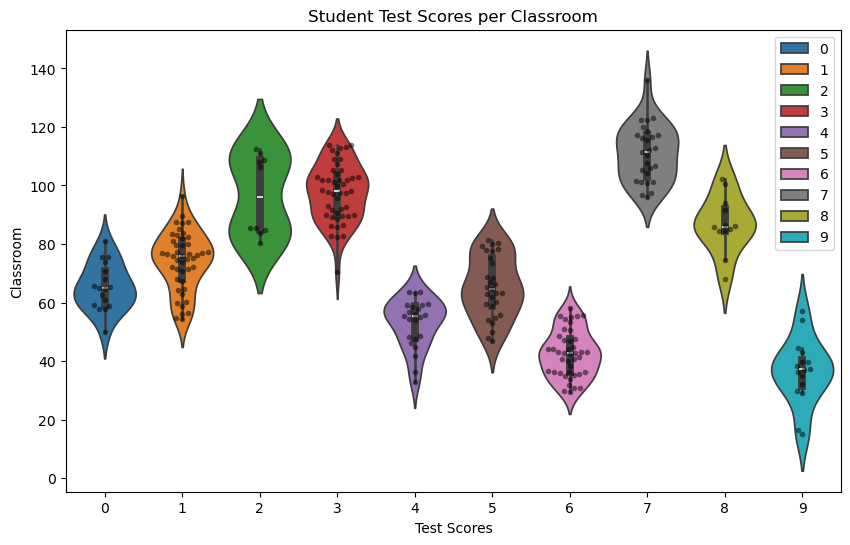

In [170]:
# Dataset parameters
num_classrooms = 10
class_sizes = rng.integers(low=5, high=51, size=num_classrooms)
mu_alpha_true = 75
sigma_alpha_true = 20 # Classrom variability
sigma_true = 10  # Individual student variability

# Generate classroom-level intercepts
alpha_true = rng.normal(mu_alpha_true, sigma_alpha_true, size=num_classrooms)

# Generate student test scores
scores = []
class_ids = []
for i in range(num_classrooms):
    scores.extend(rng.normal(alpha_true[i], sigma_true, size=class_sizes[i]))
    class_ids.extend([i] * class_sizes[i])

scores = np.array(scores)
class_ids = np.array(class_ids)

plt.figure(figsize=(10, 6))
sns.violinplot(y=scores, x=class_ids, hue=class_ids, palette='tab10')
sns.swarmplot(y=scores, x=class_ids, color='black', alpha=0.5, size=4)
plt.title('Student Test Scores per Classroom')
plt.ylabel('Classroom')
plt.xlabel('Test Scores')
plt.show()

For each test score $j$ and classroom $i$, the model is defined as:

$$ y_{ij}  \sim \mathcal{N}(\mu_{i}, \sigma_i) $$
$$ \sigma_i \sim \text{HalfNormal}(10) $$
$$ \mu_i \sim \mathcal{N}(70, 20) $$



In [156]:
with pm.Model() as non_hierarchical_model:
    mu = pm.Normal('mu', mu=70, sigma=30, shape=num_classrooms)
    sigma = pm.HalfNormal('sigma', sigma=10)
    y = pm.Normal('y', mu=mu[class_ids], sigma=sigma, observed=scores)

    trace_non_hierarchical = pm.sample(2000, tune=2000, target_accept=0.96, return_inferencedata=True)

trace_summary = az.summary(trace_non_hierarchical)
trace_summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0]   82.783  1.757   79.430   85.987      0.018    0.012    9966.0   
mu[1]   58.353  2.109   54.401   62.316      0.022    0.016    8990.0   
mu[2]   49.801  1.729   46.525   53.064      0.017    0.012    9906.0   
mu[3]   70.553  1.715   67.320   73.756      0.018    0.013    9146.0   
mu[4]  100.958  1.477   98.173  103.684      0.017    0.012    7972.0   
mu[5]   60.241  1.543   57.458   63.268      0.017    0.012    8526.0   
mu[6]  108.669  1.888  105.099  112.232      0.019    0.013   10090.0   
mu[7]   67.767  2.816   62.512   73.010      0.029    0.021    9204.0   
mu[8]   50.802  2.283   46.521   55.052      0.023    0.017    9546.0   
mu[9]   82.275  2.264   77.919   86.429      0.026    0.018    7844.0   
sigma   10.127  0.426    9.340   10.905      0.005    0.003    8969.0   

       ess_tail  r_hat  
mu[0]    6345.0    1.0  
mu[1]    5702.0    1.0  
mu[2]    5739.0    1.0  
mu[3]    6028.0    1.0  
mu[4]    5979.0    1.0  
mu[5]    6280.0    1.0  
mu[6]    6099.0    1.0  
mu[7]    6354.0    1.0  
mu[8]    6296.0    1.0  
mu[9]    5770.0    1.0  
sigma    6252.0    1.0

In [ ]:
# with pm.Model() as non_hierarchical_model:
#     intercept = pm.Normal('intercept', mu=70, sigma=10, shape=num_classrooms)
#     slope = pm.HalfNormal('slope', sigma=10)
#     error = pm.HalfNormal('error', sigma=10)
#     y = pm.Normal('y', mu=mu[class_ids], sigma=sigma, observed=scores)

#     trace_non_hierarchical = pm.sample(2000, tune=2000, target_accept=0.96, return_inferencedata=True)

# trace_summary = az.summary(trace_non_hierarchical)
# trace_summary

In [ ]:
# az.plot_forest(trace, var_names=['mu'], combined=True)
# plt.show()

# hdi = az.hdi(trace, var_names=['mu'], hdi_prob=0.95)['mu'].values
# posterior_means  = trace.posterior['mu'].stack(sample=('chain', 'draw')).values

# fig, axes = plt.subplots(num_classrooms, 1, figsize=(8, 1.2 * num_classrooms), sharex=True)
# for i, ax in enumerate(axes):
#     observed_data = scores[class_ids == i]
#     sns.boxplot(x=observed_data, ax=ax, color='tab:blue', width=0.3)

#     ax.hlines(y=0.5, xmin=hdi[i, 0], xmax=hdi[i, 1], color='tab:orange', label='95% CI', linewidth=15)
#     ax.hlines(y=0.8, xmin=hdi[i, 0], xmax=hdi[i, 1], color='tab:orange', linewidth=.001) # Plot hack to make it look nice
#     ax.scatter(posterior_means[i], [0.5]*len(posterior_means[i]), color='coral', label='Posterior Mean', alpha=0.1)
#     # ax.scatter(posterior_means[i], [0.5]*len(posterior_means[i]), color='tab:orange', label='Posterior Mean', zorder=3, alpha=0.1)
#     ax.set_title(f'Classroom {i}')
#     ax.set_yticks([])
#     ax.set_xlabel('Scores')
#     ax.legend(loc='upper right')

# plt.tight_layout()
# plt.show()

We can use global hyperpriors to inform the classroom level parameters using partial pooling.

In [ ]:
with pm.Model() as hierarchical_model:
    # Global Hyperparameters: School level
    global_mu = pm.Normal('global_mu', mu=70, sigma=30)
    global_sigma = pm.HalfNormal('global_sigma', sigma=30)

    # Classroom level
    z = pm.Normal('z', mu=0, sigma=1, shape=num_classrooms)
    mu_class = pm.Deterministic('mu_class', global_mu + z * global_sigma)
    
    # Student-level noise
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Observation level
    # y = pm.Normal('y', mu=mu[class_ids], sigma=sigma, observed=scores)
    y = pm.Normal('y', mu=pm.Deterministic('mu_student', mu_class[class_ids]), sigma=sigma, observed=scores)

    trace_hierarchical = pm.sample(2000, tune=2000, target_accept=0.96, return_inferencedata=True)

trace_summary_hierarchical = az.summary(trace_hierarchical)
trace_summary_hierarchical

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_mu, global_sigma, z, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
global_mu        75.871  7.149  62.438   89.495      0.193    0.137    1371.0   
z[0]             -0.619  0.356  -1.254    0.067      0.010    0.007    1205.0   
z[1]              0.080  0.319  -0.544    0.649      0.009    0.006    1351.0   
z[2]             -0.329  0.342  -0.995    0.282      0.009    0.007    1304.0   
z[3]             -0.864  0.380  -1.564   -0.159      0.011    0.008    1163.0   
...                 ...    ...     ...      ...        ...      ...       ...   
mu_student[301]  86.223  3.399  79.525   92.348      0.037    0.026    8657.0   
mu_student[302]  86.223  3.399  79.525   92.348      0.037    0.026    8657.0   
mu_student[303]  86.223  3.399  79.525   92.348      0.037    0.026    8657.0   
mu_student[304]  86.223  3.399  79.525   92.348      0.037    0.026    8657.0   
mu_student[305]  86.223  3.399  79.525   92.348      0.037    0.026    8657.0   

                 ess_tail  r_hat  
global_mu          1975.0    1.0  
z[0]               2251.0    1.0  
z[1]               2210.0    1.0  
z[2]               2220.0    1.0  
z[3]               1996.0    1.0  
...                   ...    ...  
mu_student[301]    5394.0    1.0  
mu_student[302]    5394.0    1.0  
mu_student[303]    5394.0    1.0  
mu_student[304]    5394.0    1.0  
mu_student[305]    5394.0    1.0  

[329 rows x 9 columns]

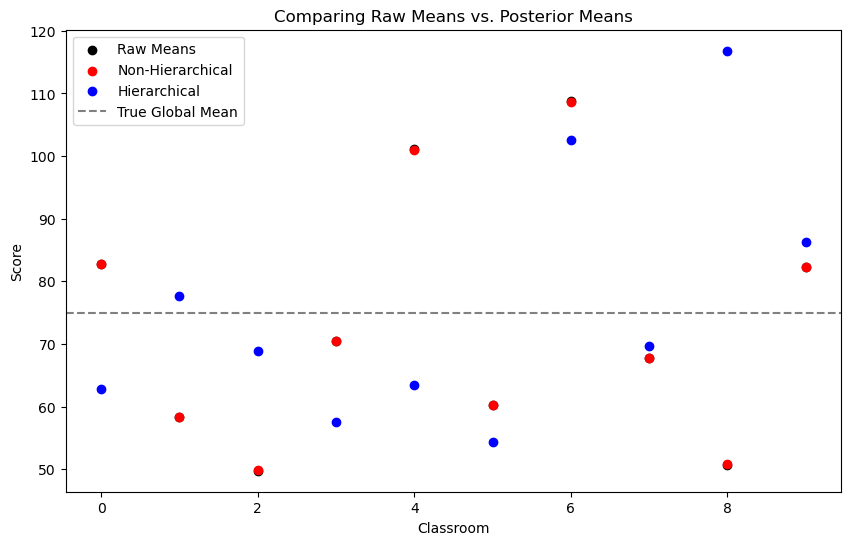

In [158]:
posterior_means_non_hierarchical = trace_non_hierarchical.posterior['mu'].mean(dim=["chain","draw"]).values
posterior_means_hierarchical = trace_hierarchical.posterior['mu'].mean(dim=["chain","draw"]).values

# Raw means (empirical average within each classroom)
raw_means = [scores[class_ids == i].mean() for i in range(num_classrooms)]

# Plot: raw means vs. posterior means
plt.figure(figsize=(10, 6))
plt.scatter(range(num_classrooms), raw_means, color='black', label='Raw Means')
plt.scatter(range(num_classrooms), posterior_means_non_hierarchical, color='red', label='Non-Hierarchical')
plt.scatter(range(num_classrooms), posterior_means_hierarchical, color='blue', label='Hierarchical')
plt.axhline(mu_alpha_true, color='gray', linestyle='--', label='True Global Mean')
plt.legend()
plt.xlabel('Classroom')
plt.ylabel('Score')
plt.title('Comparing Raw Means vs. Posterior Means')
plt.show()

In [162]:
# Compare how well each model might predict out-of-sample data
loo_non_hierarchical = az.loo(trace_non_hierarchical)
loo_hierarchical = az.loo(trace_hierarchical)

print("LOO - Non-Hierarchical Model:", loo_non_hierarchical)
print("LOO - Hierarchical Model:", loo_hierarchical)

TypeError: log likelihood not found in inference data object

In [110]:
# cols_to_keep = ['mean', 'sd', 'hdi_3%', 'hdi_97%']
cols_to_keep = ['mean']
combined = trace_summary[cols_to_keep].merge(trace_summary_hierarchical[cols_to_keep], left_index=True, right_index=True, suffixes=('','_hierarchical'))
combined['mu_true'] = np.append(alpha_true, 0)
combined

mean  mean_hierarchical    mu_true
mu[0]  86.047             86.036  85.460314
mu[1]  72.199             72.215  71.587348
mu[2]  73.420             73.431  73.314832
mu[3]  71.100             71.103  70.985334
mu[4]  74.900             74.904  75.002223
sigma   1.058              1.059   0.000000

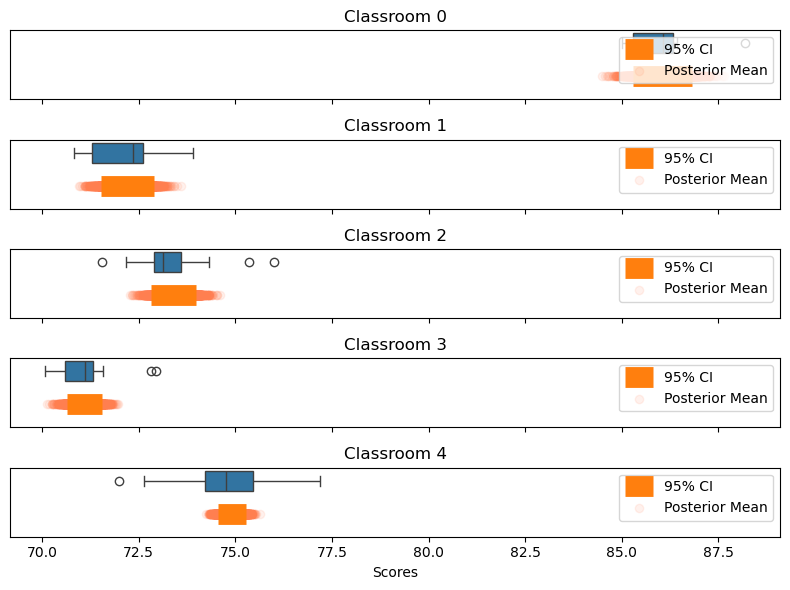

In [111]:
hdi = az.hdi(trace, var_names=['mu'], hdi_prob=0.95)['mu'].values
posterior_means  = trace.posterior['mu'].stack(sample=('chain', 'draw')).values

fig, axes = plt.subplots(num_classrooms, 1, figsize=(8, 1.2 * num_classrooms), sharex=True)
for i, ax in enumerate(axes):
    observed_data = scores[class_ids == i]
    sns.boxplot(x=observed_data, ax=ax, color='tab:blue', width=0.3)

    ax.hlines(y=0.5, xmin=hdi[i, 0], xmax=hdi[i, 1], color='tab:orange', label='95% CI', linewidth=15)
    ax.hlines(y=0.8, xmin=hdi[i, 0], xmax=hdi[i, 1], color='tab:orange', linewidth=.001) # Plot hack to make it look nice
    ax.scatter(posterior_means[i], [0.5]*len(posterior_means[i]), color='coral', label='Posterior Mean', alpha=0.1)
    ax.set_title(f'Classroom {i}')
    ax.set_yticks([])
    ax.set_xlabel('Scores')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

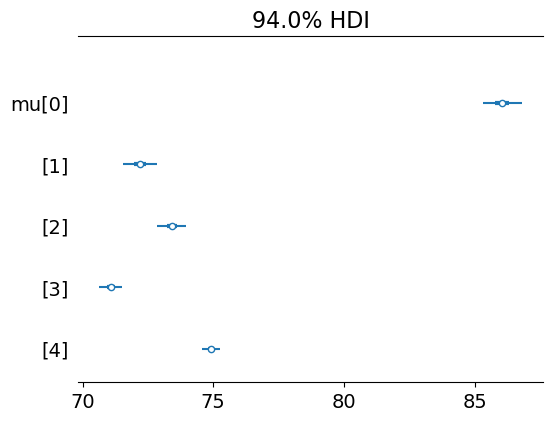

In [112]:
az.plot_forest(trace, var_names=['mu'], combined=True)
plt.show()

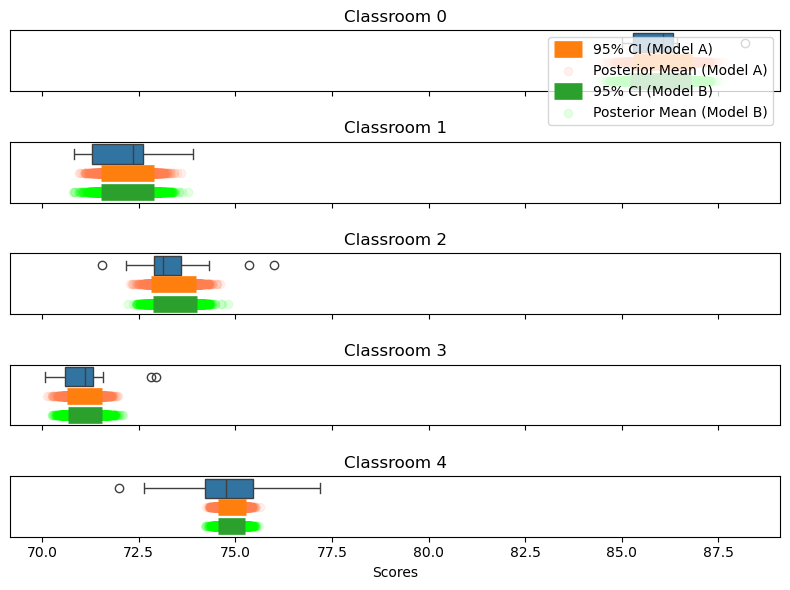

In [113]:
# Compute HDI and posterior means for both models
hdi_non_hierarchical = az.hdi(trace, var_names=['mu'], hdi_prob=0.95)['mu'].values
posterior_means_non_hierarchical = trace.posterior['mu'].stack(sample=('chain', 'draw')).values

hdi_hierarchical = az.hdi(trace_hierarchical, var_names=['mu'], hdi_prob=0.95)['mu'].values
posterior_means_hierarchical = trace_hierarchical.posterior['mu'].stack(sample=('chain', 'draw')).values

# Create subplots for each classroom
fig, axes = plt.subplots(num_classrooms, 1, figsize=(8, 1.2 * num_classrooms), sharex=True)

for i, ax in enumerate(axes):
    observed_data = scores[class_ids == i]
    
    # Boxplot for observed scores
    sns.boxplot(x=observed_data, ax=ax, color='tab:blue', width=0.5)

    # HDI and posterior means for Model A (non-hierarchical)
    ax.hlines(y=0.5, xmin=hdi_non_hierarchical[i, 0], xmax=hdi_non_hierarchical[i, 1], 
              color='tab:orange', label='95% CI (Model A)', linewidth=12)
    ax.scatter(posterior_means_non_hierarchical[i], [0.5] * len(posterior_means_non_hierarchical[i]), 
               color='coral', label='Posterior Mean (Model A)', alpha=0.1)

    # HDI and posterior means for Model B (hierarchical)
    ax.hlines(y=1, xmin=hdi_hierarchical[i, 0], xmax=hdi_hierarchical[i, 1], 
              color='tab:green', label='95% CI (Model B)', linewidth=12)
    ax.scatter(posterior_means_hierarchical[i], [1] * len(posterior_means_hierarchical[i]), 
               color='lime', label='Posterior Mean (Model B)', alpha=0.1)

    ax.hlines(y=1.2, xmin=hdi[i, 0], xmax=hdi[i, 1], color='white', linewidth=.001) # Plot hack to make it look nice
    ax.set_title(f'Classroom {i}')
    ax.set_yticks([])
    ax.set_xlabel('Scores')

    if i == 0:  # Add a legend to the first subplot
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

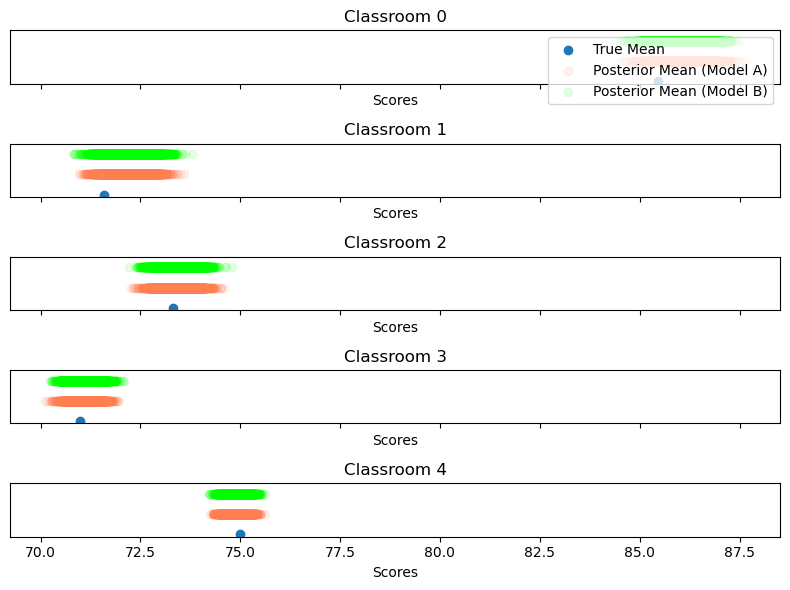

In [114]:
# Compute HDI and posterior means for both models
hdi_non_hierarchical = az.hdi(trace, var_names=['mu'], hdi_prob=0.95)['mu'].values
posterior_means_non_hierarchical = trace.posterior['mu'].stack(sample=('chain', 'draw')).values

hdi_hierarchical = az.hdi(trace_hierarchical, var_names=['mu'], hdi_prob=0.95)['mu'].values
posterior_means_hierarchical = trace_hierarchical.posterior['mu'].stack(sample=('chain', 'draw')).values

# Create subplots for each classroom
fig, axes = plt.subplots(num_classrooms, 1, figsize=(8, 1.2 * num_classrooms), sharex=True)

for i, ax in enumerate(axes):
    observed_data = scores[class_ids == i]
    
    # Boxplot for observed scores
    # sns.boxplot(x=observed_data, ax=ax, color='tab:blue', width=0.5)
    ax.scatter(alpha_true[i], 0, label='True Mean')

    # HDI and posterior means for Model A (non-hierarchical)
    # ax.hlines(y=0.5, xmin=hdi_non_hierarchical[i, 0], xmax=hdi_non_hierarchical[i, 1], 
    #           color='tab:orange', label='95% CI (Model A)', linewidth=12)
    ax.scatter(posterior_means_non_hierarchical[i], [0.5] * len(posterior_means_non_hierarchical[i]), 
               color='coral', label='Posterior Mean (Model A)', alpha=0.1)

    # HDI and posterior means for Model B (hierarchical)
    # ax.hlines(y=1, xmin=hdi_hierarchical[i, 0], xmax=hdi_hierarchical[i, 1], 
    #           color='tab:green', label='95% CI (Model B)', linewidth=12)
    ax.scatter(posterior_means_hierarchical[i], [1] * len(posterior_means_hierarchical[i]), 
               color='lime', label='Posterior Mean (Model B)', alpha=0.1)

    ax.hlines(y=1.2, xmin=hdi[i, 0], xmax=hdi[i, 1], color='white', linewidth=.001) # Plot hack to make it look nice
    ax.set_title(f'Classroom {i}')
    ax.set_yticks([])
    ax.set_xlabel('Scores')

    if i == 0:  # Add a legend to the first subplot
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [115]:
results = []
for i in range(num_classrooms):
    data = {
        'class': i,
        'model': 'non-hierarchical',
        'posterior_means': posterior_means_non_hierarchical[i],
    }
    results.append(pd.DataFrame(data))
    data = {
        'class': i,
        'model': 'hierarchical',
        'posterior_means': posterior_means_hierarchical[i]
    }
    results.append(pd.DataFrame(data))

results = pd.concat(results)
results

class             model  posterior_means
0          0  non-hierarchical        86.642176
1          0  non-hierarchical        85.958806
2          0  non-hierarchical        86.665910
3          0  non-hierarchical        86.146792
4          0  non-hierarchical        86.123812
...      ...               ...              ...
15995      4      hierarchical        74.827815
15996      4      hierarchical        74.994348
15997      4      hierarchical        74.808547
15998      4      hierarchical        74.897685
15999      4      hierarchical        75.056174

[120000 rows x 3 columns]

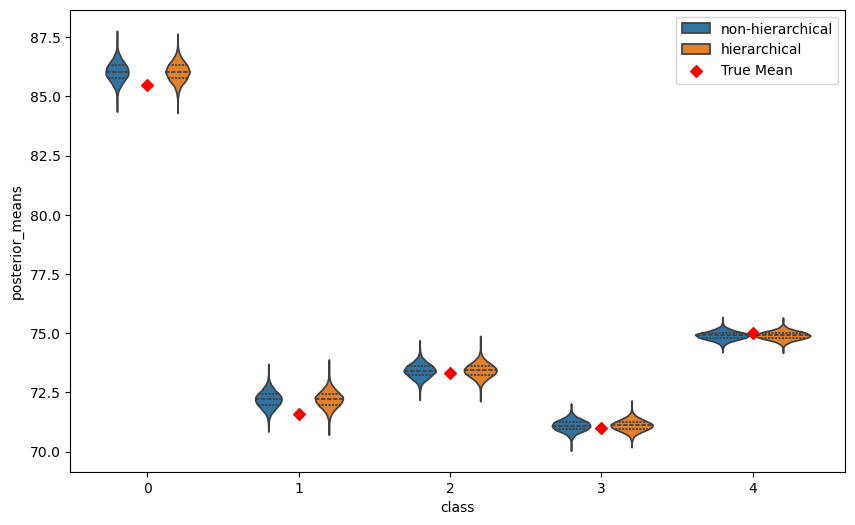

In [116]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=results, x="class", y="posterior_means", hue="model", #split=True,
                inner="quart", gap=0.1)
plt.scatter([i for i in range(num_classrooms)], alpha_true, label='True Mean', color='red', marker='D')
plt.legend()
plt.show()

Level 1 - Global Hyperpriors:

$ \mu_\alpha \sim \mathcal{N}(70, 20) $ : (mu=70) was chosen to be reasonably close to the true mean used in data generation (mu_alpha_true = 75). This centers the prior around a plausible value but is wide enough to allow flexibility. Standard Deviation (sigma=20): A relatively large standard deviation to reflect uncertainty about the true mean. This makes the prior weakly informative, allowing the data to primarily influence the posterior.

$ \sigma_\alpha \sim \text{HalfNormal}(10) $ : Reflects a belief that the variability between classrooms is likely to be within a reasonable range

Level 2 - Classroom-Level Parameters:

$ \alpha_c  \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) $: where $ \alpha_c $ represents the mean score for the classroom $c$

Level 3 - Observation-Level Likelihood: 

$ y_i  \sim \mathcal{N}(\alpha_{c[i]}, \sigma) $

Where: 
- $ c[i] $ maps observation $i$ to its corresponding classroom $c$ based on class_ids
- $ \sigma \sim \text{HalfNormal}(20) $ represents the residual standard deviation common to all observations.

In [ ]:
# Define the Hierarchical Model
with pm.Model() as model:
    # Hyperpriors for group nodes
    mu_alpha = pm.Normal('mu_alpha', mu=70, sigma=20)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=10) # global variability, 
    
    # Classroom-level parameters
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=num_classrooms)
    
    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=20)
    y = pm.Normal('y', mu=alpha[class_ids], sigma=sigma, observed=scores)

In [ ]:
# Sample from the Posterior
with model:
    trace = pm.sample(2000, tune=2000, target_accept=0.96, return_inferencedata=True)

NameError: name 'hierarchical_model' is not defined

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha     78.503  5.177  68.429   88.010      0.072    0.051    5513.0   
sigma_alpha  10.962  3.802   4.899   18.163      0.052    0.037    5437.0   
sigma        14.757  1.102  12.710   16.827      0.012    0.008    8949.0   

             ess_tail  r_hat  
mu_alpha       4601.0    1.0  
sigma_alpha    5492.0    1.0  
sigma          5672.0    1.0  


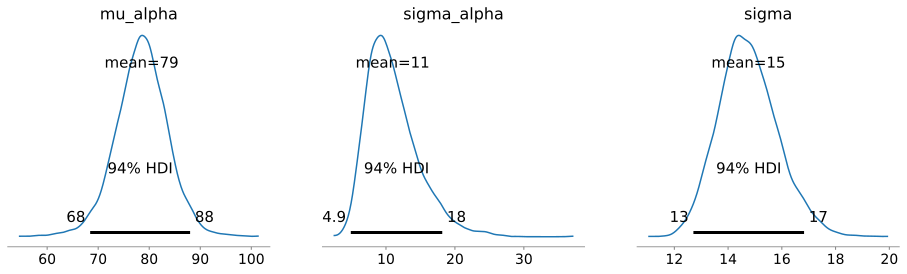

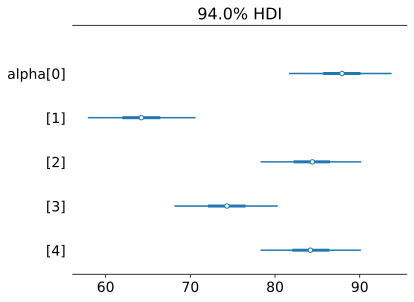

In [44]:
# Summary of the posterior
print(az.summary(trace, var_names=['mu_alpha', 'sigma_alpha', 'sigma']))

# Plot the posterior distributions
az.plot_posterior(trace, var_names=['mu_alpha', 'sigma_alpha', 'sigma'], figsize=(16,4))
plt.show()

# Plot classroom-level estimates
az.plot_forest(trace, var_names=['alpha'], combined=True)
plt.show()

## Time Series Forecasting

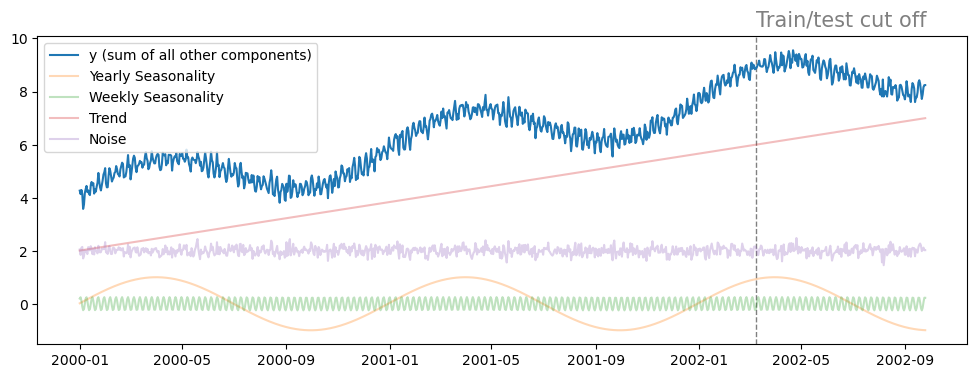

In [31]:
rng = np.random.default_rng(42)
t = np.arange(1, 1000)
df = pd.DataFrame({
    'yearly_seasonality': np.sin(2*np.pi*t/ 365),
    'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 365*52),
    'trend': 2+t*.005,
    'noise': rng.normal(2, scale=0.15, size=len(t)),
},
    index=pd.date_range(start='2000-01-01', periods=len(t), freq='D')
)
df['total'] = df['yearly_seasonality'] + df['weekly_seasonality'] + df['trend'] + df['noise']

train_cutoff = int(len(df) * 0.8)
target_df = df.loc[:, 'total']
train_df, test_df = target_df.iloc[:train_cutoff], target_df.iloc[train_cutoff:]

def plot_df(df, train_df):
    plt.axvline(x=train_df.index[-1], color='gray', linestyle='--', linewidth=1)
    plt.text(train_df.index[-1], train_df.max()+2, 'Train/test cut off',
        color='gray', fontsize=15, va='top', ha='left')

    plt.plot(df['total'], label='y (sum of all other components)')
    plt.plot(df['yearly_seasonality'], label='Yearly Seasonality', alpha=.3)
    plt.plot(df['weekly_seasonality'], label='Weekly Seasonality', alpha=.3)
    plt.plot(df['trend'], label='Trend', alpha=.3)
    plt.plot(df['noise'], label='Noise', alpha=.3)
    plt.legend()
    plt.show()

plot_df(df, train_df)

In [8]:
# t = np.arange(1, 100)
# df = pd.DataFrame({
#     'yearly_seasonality': np.sin(2 * np.pi * t / 12),
#     # 'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 12*52),
#     'trend': 3+t*0.005,
#     'noise': rng.normal(2, scale=0.15, size=len(t)),
# },
#     index=pd.date_range(start='2000-01-01', periods=len(t), freq='ME')
# )
# # df['total'] = df['yearly_seasonality'] + df['weekly_seasonality'] + df['trend'] + df['noise']
# df['total'] = df['yearly_seasonality'] + df['trend'] + df['noise']

# train_cutoff = int(len(df) * 0.8)
# target_df = df.loc[:, 'total']
# train_df, test_df = target_df.iloc[:train_cutoff], target_df.iloc[train_cutoff:]

# plot_df(df, train_df)

The Bayesian model includes three components:
- Trend: a linear function with an intercept and slope.
- Seasonality: a sinusoidal function with amplitude, frequency, and phase.
- Noise: gaussian noise with an unknown standard deviation.

In [ ]:
y_test = test_df.values
y_train = train_df.values
t_train = t[:len(train_df)]

with pm.Model() as model:
    # Priors for the trend
    intercept = pm.Normal('intercept', mu=5, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=1)
    
    # Priors for the seasonality
    amplitude = pm.HalfNormal('amplitude', sigma=10)
    # Frequency as a fraction of the sampling rate
    # monthly seasonality implies frequency around 1/12 ≈ 0.083
    frequency = pm.Uniform('frequency', lower=0.05, upper=.1)  
    phase = pm.Uniform('phase', lower=0, upper=2 * np.pi)
    
    # Prior for the noise
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of the time series
    mu = intercept + \
        slope * t_train + \
        amplitude * pm.math.sin(2 * np.pi * frequency * t_train + phase)
    
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

- `tune`: Number of tuning (burn-in) steps.
- `target_accept`: Adjusts the step size for better convergence; higher values reduce the chance of divergent samples.

In [10]:
with model:
    trace = pm.sample(
        draws=2000,
        tune=1000,
        nuts={'target_accept': 0.99, 'max_treedepth': 15},
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, amplitude, frequency, phase, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 384 seconds.


In [11]:
# az.plot_energy(trace)
# plt.show()

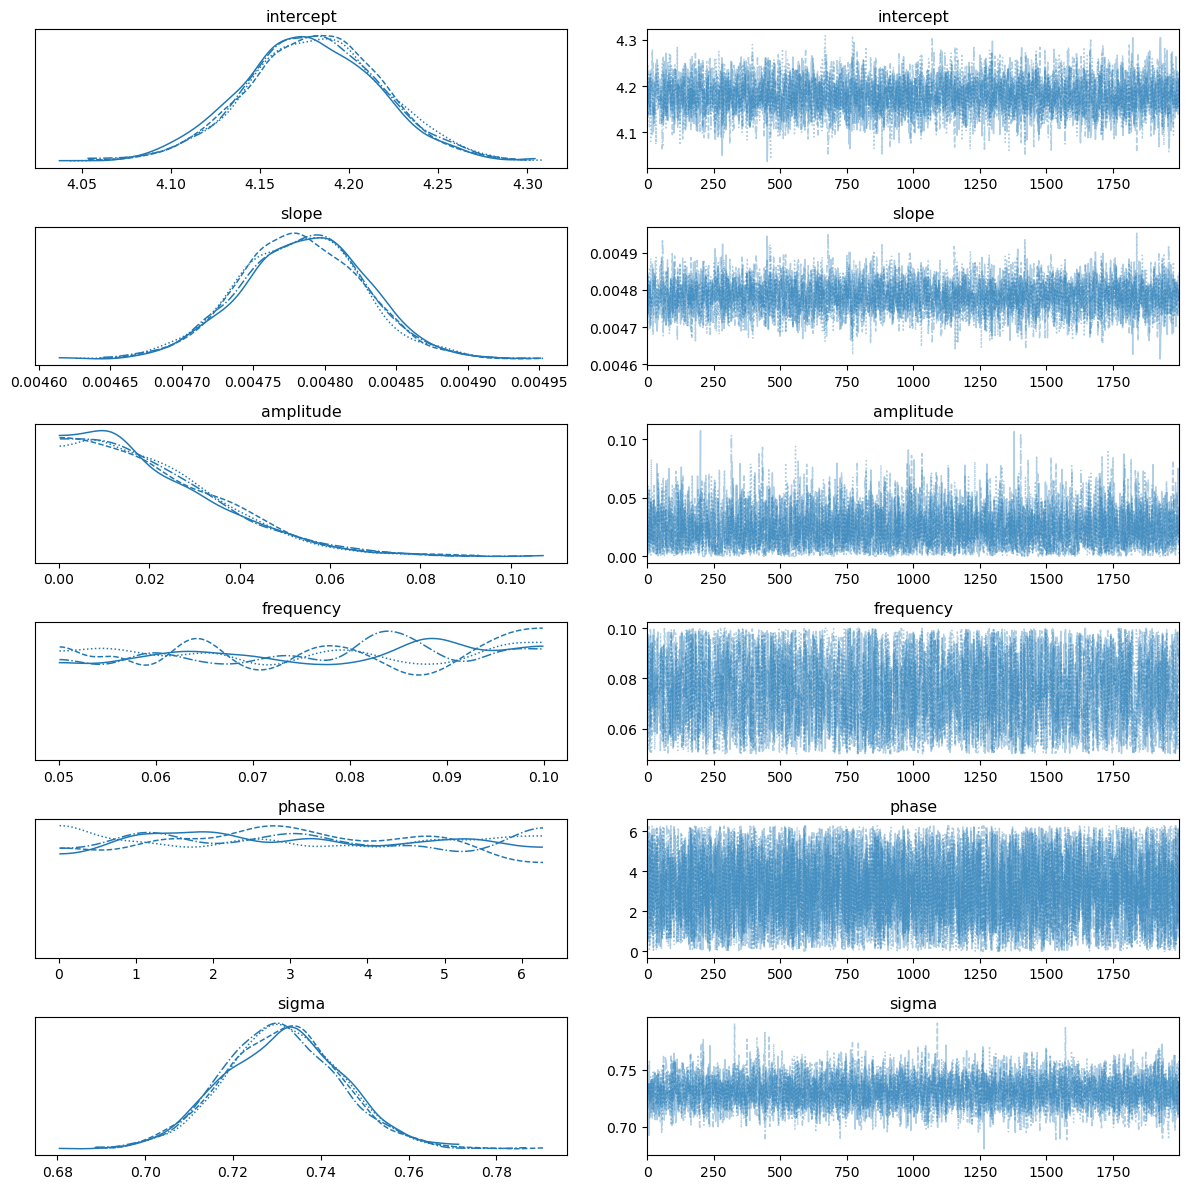

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  4.18  0.04    4.11     4.25       0.00     0.00   3511.29   
slope      0.00  0.00    0.00     0.00       0.00     0.00   3503.28   
amplitude  0.02  0.02    0.00     0.05       0.00     0.00   3437.47   
frequency  0.08  0.01    0.05     0.10       0.00     0.00   3075.21   
phase      3.12  1.80    0.04     5.93       0.02     0.02   5904.14   
sigma      0.73  0.01    0.71     0.76       0.00     0.00   4952.88   

           ess_tail  r_hat  
intercept   3716.28    1.0  
slope       3974.07    1.0  
amplitude   2738.17    1.0  
frequency   3239.53    1.0  
phase       3260.08    1.0  
sigma       5066.13    1.0

In [12]:
# Plot trace and posterior distributions
az.plot_trace(trace)
plt.tight_layout()
plt.show()
az.summary(trace, round_to=2)

In [13]:
t_future = np.arange(len(train_df)+1, len(df)+1)
posterior = trace.posterior

# Calculate the expected value for the forecast
# Expand dimensions to broadcast properly
intercept_samples = posterior['intercept'].values.flatten()[:, np.newaxis]
slope_samples = posterior['slope'].values.flatten()[:, np.newaxis]
amplitude_samples = posterior['amplitude'].values.flatten()[:, np.newaxis]
frequency_samples = posterior['frequency'].values.flatten()[:, np.newaxis]
phase_samples = posterior['phase'].values.flatten()[:, np.newaxis]
sigma_samples = posterior['sigma'].values.flatten()[:, np.newaxis]

# Compute the mean forecast
mu_forecast = (intercept_samples +
               slope_samples * t_future +
               amplitude_samples * np.sin(2 * np.pi * frequency_samples * t_future + phase_samples))

# Sample noise for the forecast
y_forecast = mu_forecast + np.random.normal(0, sigma_samples, size=mu_forecast.shape)

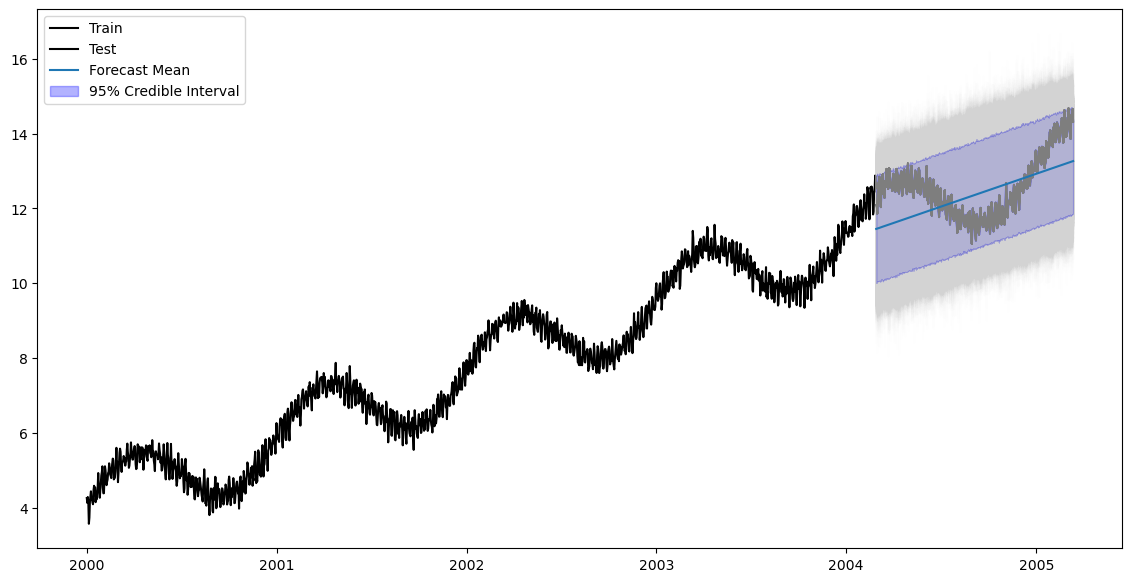

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(train_df, label='Train', color='black')
plt.plot(test_df, label='Test', color='black')

plt.plot(test_df.index, y_forecast.T, color='lightgrey', alpha=0.01)
plt.plot(test_df.index, mu_forecast.mean(axis=0), color='tab:blue', label='Forecast Mean')
lower = np.percentile(y_forecast, 2.5, axis=0)
upper = np.percentile(y_forecast, 97.5, axis=0)
plt.fill_between(test_df.index, lower, upper, color='blue', alpha=0.3, label='95% Credible Interval')
plt.legend()
plt.show()

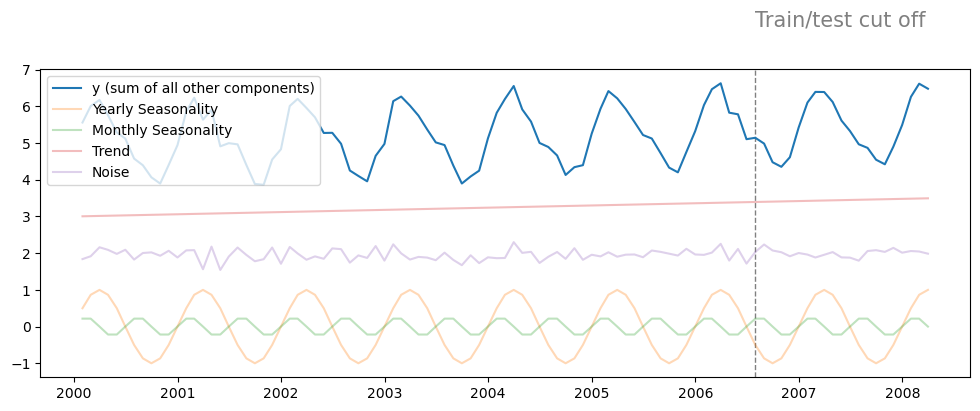

In [15]:
t = np.arange(1, 100)
df = pd.DataFrame({
    'yearly_seasonality': np.sin(2 * np.pi * t / 12),
    'monthly_seasonality': 0.25*np.sin(2*np.pi*t / 12*1550),
    'trend': 3 + t * 0.005,
    'noise': rng.normal(2, scale=0.15, size=len(t)),
},
    index=pd.date_range(start='2000-01-01', periods=len(t), freq='ME')
)
df['total'] = df['yearly_seasonality'] + df['monthly_seasonality'] + df['trend'] + df['noise']

train_cutoff = int(len(df) * 0.8)
target_df = df.loc[:, 'total']
train_df, test_df = target_df.iloc[:train_cutoff], target_df.iloc[train_cutoff:]

def plot_df(df, train_df):
    plt.axvline(x=train_df.index[-1], color='gray', linestyle='--', linewidth=1)
    plt.text(train_df.index[-1], train_df.max()+2, 'Train/test cut off',
        color='gray', fontsize=15, va='top', ha='left')

    plt.plot(df['total'], label='y (sum of all other components)')
    plt.plot(df['yearly_seasonality'], label='Yearly Seasonality', alpha=.3)
    plt.plot(df['monthly_seasonality'], label='Monthly Seasonality', alpha=.3)
    plt.plot(df['trend'], label='Trend', alpha=.3)
    plt.plot(df['noise'], label='Noise', alpha=.3)
    plt.legend()
    plt.show()

plot_df(df, train_df)

In [16]:
# y_test = test_df.values
# y_train = train_df.values
# t_train = np.arange(1, len(train_df)+1)

# with pm.Model() as model:
#     # Priors for the trend
#     intercept = pm.Normal('intercept', mu=5, sigma=10)
#     slope = pm.Normal('slope', mu=0, sigma=1)
    
#     # Priors for seasonality
#     amplitude_1 = pm.HalfNormal('amplitude_1', sigma=10)
#     frequency_1 = pm.Uniform('frequency_1', lower=0.05, upper=.1)  
#     phase_1 = pm.Uniform('phase_1', lower=0, upper=2 * np.pi)

#     amplitude_2 = pm.HalfNormal('amplitude_2', sigma=2)
#     frequency_2 = pm.Uniform('frequency_2', lower=0.05/12, upper=.1/12)  
#     phase_2 = pm.Uniform('phase_2', lower=0, upper=2 * np.pi)
    
#     # Prior for the noise
#     sigma = pm.HalfNormal('sigma', sigma=1)
    
#     # Expected value of the time series
#     mu = intercept + \
#         slope * t_train + \
#         amplitude_1 * pm.math.sin(2 * np.pi * frequency_1 * t_train + phase_1) + \
#         amplitude_2 * pm.math.sin(2 * np.pi * frequency_2 * t_train + phase_2)
    
#     # Likelihood (sampling distribution) of observations
#     y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

#     trace = pm.sample(
#         draws=2000,
#         tune=1000,
#         nuts={'target_accept': 0.99, 'max_treedepth': 15},
#         return_inferencedata=True
#     )

In [17]:
y_test = test_df.values
y_train = train_df.values
t_train = np.arange(1, len(train_df)+1)

with pm.Model() as model:
    # Priors for the trend
    intercept = pm.Normal('intercept', mu=4, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=1)
    
    # Priors for seasonality
    amplitude_1 = pm.HalfNormal('amplitude_1', sigma=10)
    frequency_1 = pm.Uniform('frequency_1', lower=0.05, upper=.1)  
    phase_1 = pm.Uniform('phase_1', lower=0, upper=2 * np.pi)

    amplitude_2 = pm.HalfNormal('amplitude_2', sigma=2)
    frequency_2 = pm.Uniform('frequency_2', lower=0.05/12, upper=.1/12)  
    phase_2 = pm.Uniform('phase_2', lower=0, upper=2 * np.pi)
    
    # Prior for the noise
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of the time series
    mu = intercept + \
        slope * t_train + \
        amplitude_1 * pm.math.sin(2 * np.pi * frequency_1 * t_train + phase_1) + \
        amplitude_2 * pm.math.sin(2 * np.pi * frequency_2 * t_train + phase_2)
    
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

    trace = pm.sample(
        draws=2000,
        tune=1000,
        nuts={'target_accept': 0.99, 'max_treedepth': 15},
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, amplitude_1, frequency_1, phase_1, amplitude_2, frequency_2, phase_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


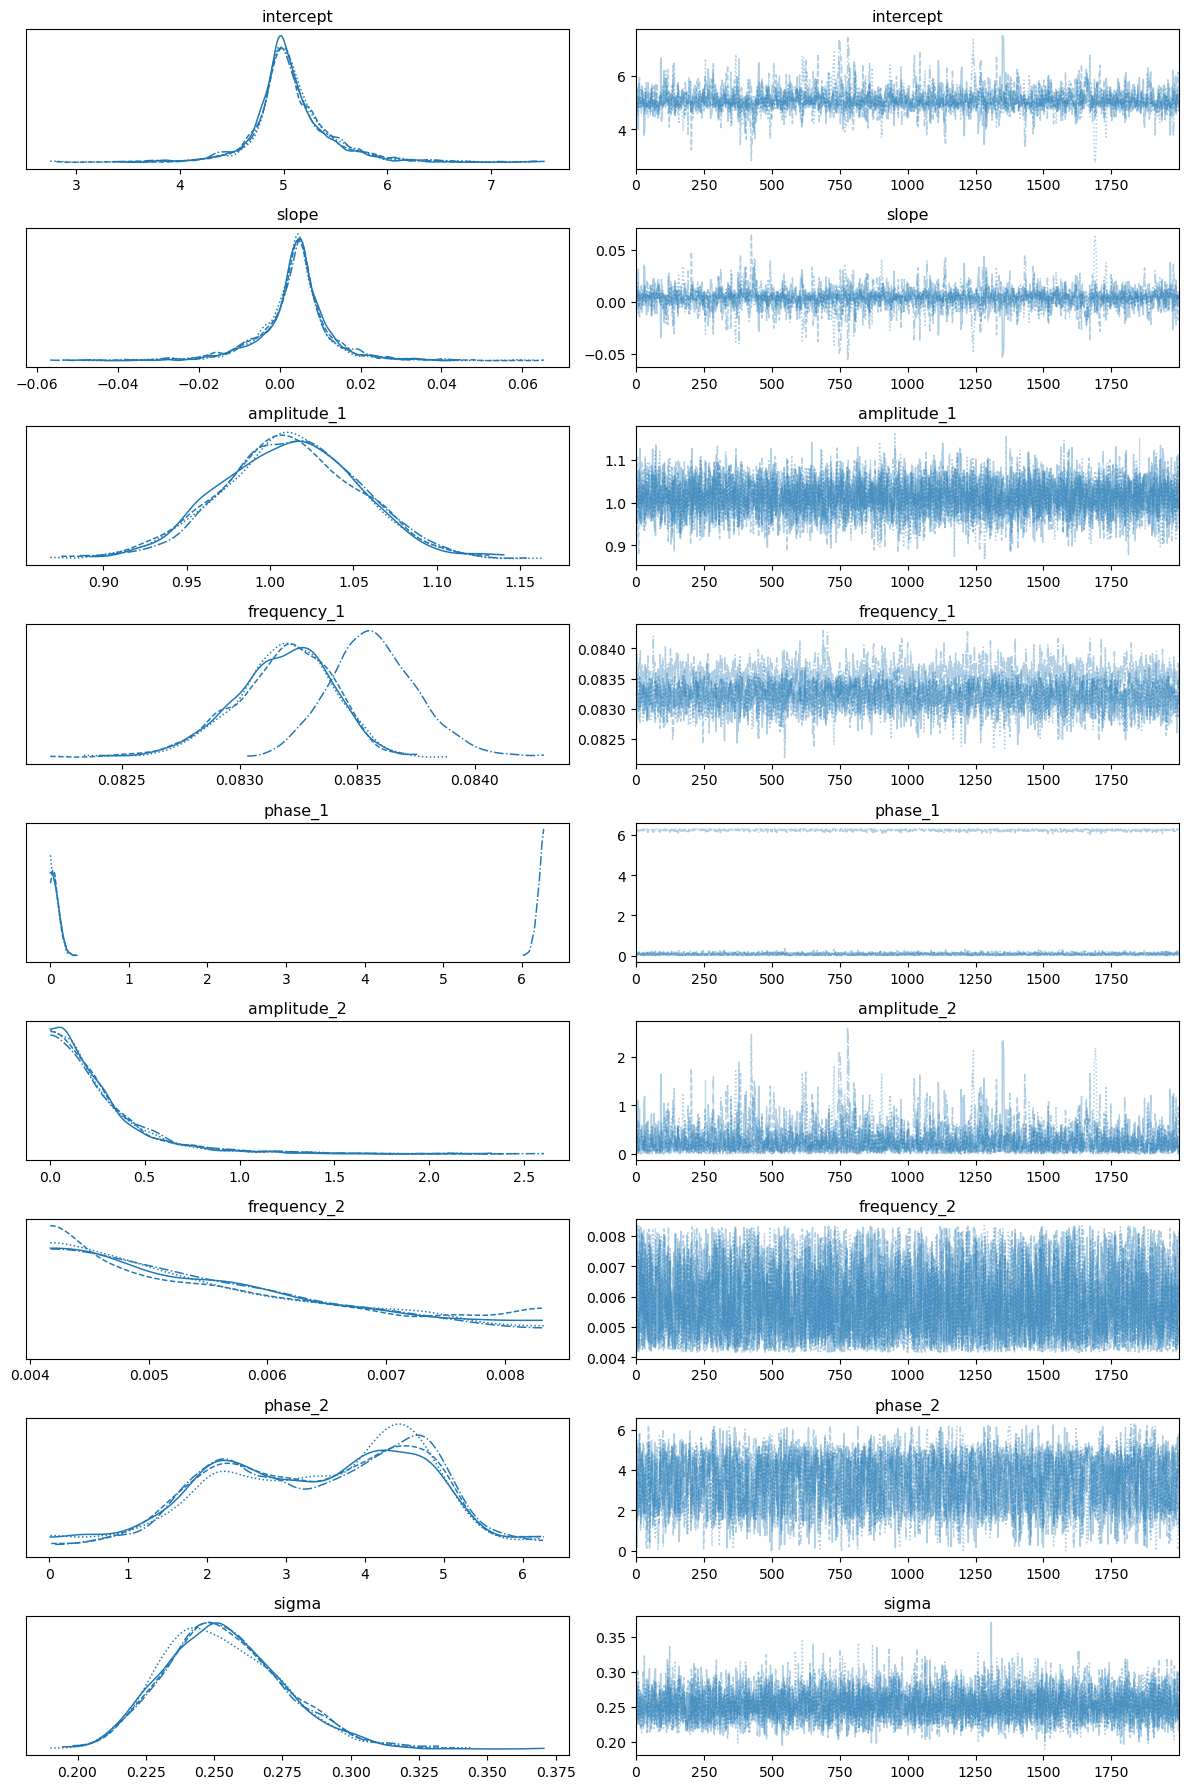

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept    5.08  0.39    4.36     5.86       0.01     0.01   1548.68   
slope        0.00  0.01   -0.01     0.02       0.00     0.00   1493.50   
amplitude_1  1.01  0.04    0.94     1.09       0.00     0.00   5837.27   
frequency_1  0.08  0.00    0.08     0.08       0.00     0.00      9.52   
phase_1      1.61  2.66    0.00     6.26       1.33     1.02      7.15   
amplitude_2  0.27  0.28    0.00     0.74       0.01     0.01   1916.07   
frequency_2  0.01  0.00    0.00     0.01       0.00     0.00   4646.89   
phase_2      3.40  1.31    0.98     5.53       0.03     0.02   2604.69   
sigma        0.25  0.02    0.21     0.29       0.00     0.00   5546.74   

             ess_tail  r_hat  
intercept     1652.16   1.00  
slope         1673.42   1.00  
amplitude_1   4822.62   1.00  
frequency_1     31.91   1.33  
phase_1         28.94   1.53  
amplitude_2   2100.31   1.00  
frequency_2   4205.10   1.00  
phase_2       3427.53   1.00  
sigma         4631.32   1.00

In [18]:
# Plot trace and posterior distributions
az.plot_trace(trace)
plt.tight_layout()
plt.show()
az.summary(trace, round_to=2)

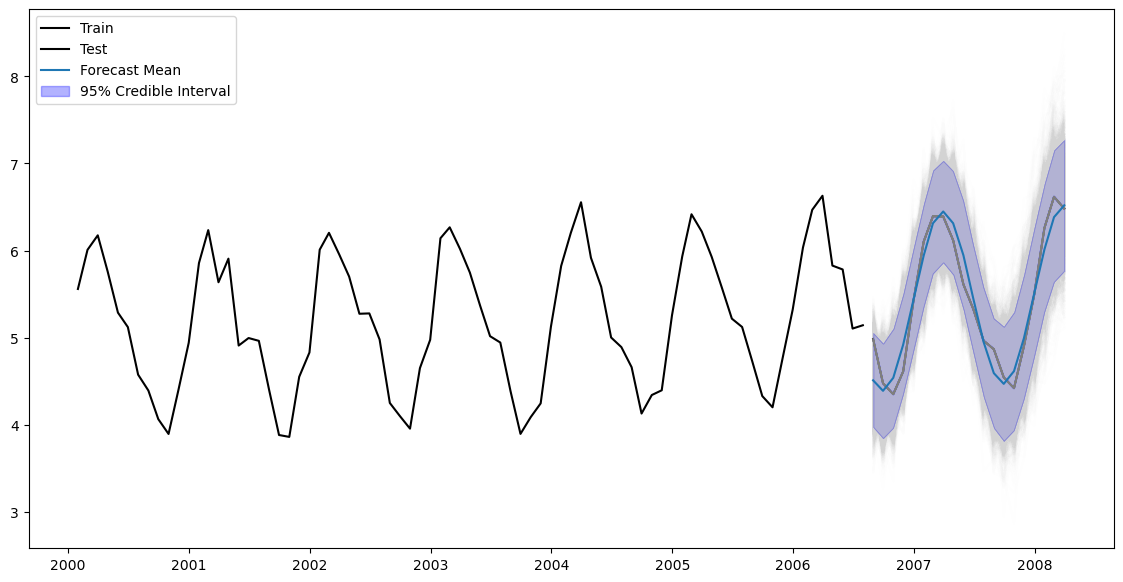

In [19]:
t_future = np.arange(len(train_df)+1, len(df)+1)
posterior = trace.posterior

# Calculate the expected value for the forecast
# Expand dimensions to broadcast properly
intercept_samples = posterior['intercept'].values.flatten()[:, np.newaxis]
slope_samples = posterior['slope'].values.flatten()[:, np.newaxis]
amplitude_1_samples = posterior['amplitude_1'].values.flatten()[:, np.newaxis]
frequency_1_samples = posterior['frequency_1'].values.flatten()[:, np.newaxis]
phase_1_samples = posterior['phase_1'].values.flatten()[:, np.newaxis]
amplitude_2_samples = posterior['amplitude_2'].values.flatten()[:, np.newaxis]
frequency_2_samples = posterior['frequency_2'].values.flatten()[:, np.newaxis]
phase_2_samples = posterior['phase_2'].values.flatten()[:, np.newaxis]
sigma_samples = posterior['sigma'].values.flatten()[:, np.newaxis]

# Compute the mean forecast
mu_forecast = (intercept_samples +
               slope_samples * t_future +
               amplitude_1_samples * np.sin(2 * np.pi * frequency_1_samples * t_future + phase_1_samples) + 
               amplitude_2_samples * np.sin(2 * np.pi * frequency_2_samples * t_future + phase_2_samples))

# Sample noise for the forecast
y_forecast = mu_forecast + np.random.normal(0, sigma_samples, size=mu_forecast.shape)

plt.figure(figsize=(14, 7))
plt.plot(train_df, label='Train', color='black')
plt.plot(test_df, label='Test', color='black')

plt.plot(test_df.index, y_forecast.T, color='lightgrey', alpha=0.01)
plt.plot(test_df.index, mu_forecast.mean(axis=0), color='tab:blue', label='Forecast Mean')
lower = np.percentile(y_forecast, 2.5, axis=0)
upper = np.percentile(y_forecast, 97.5, axis=0)
plt.fill_between(test_df.index, lower, upper, color='blue', alpha=0.3, label='95% Credible Interval')
plt.legend()
plt.show()

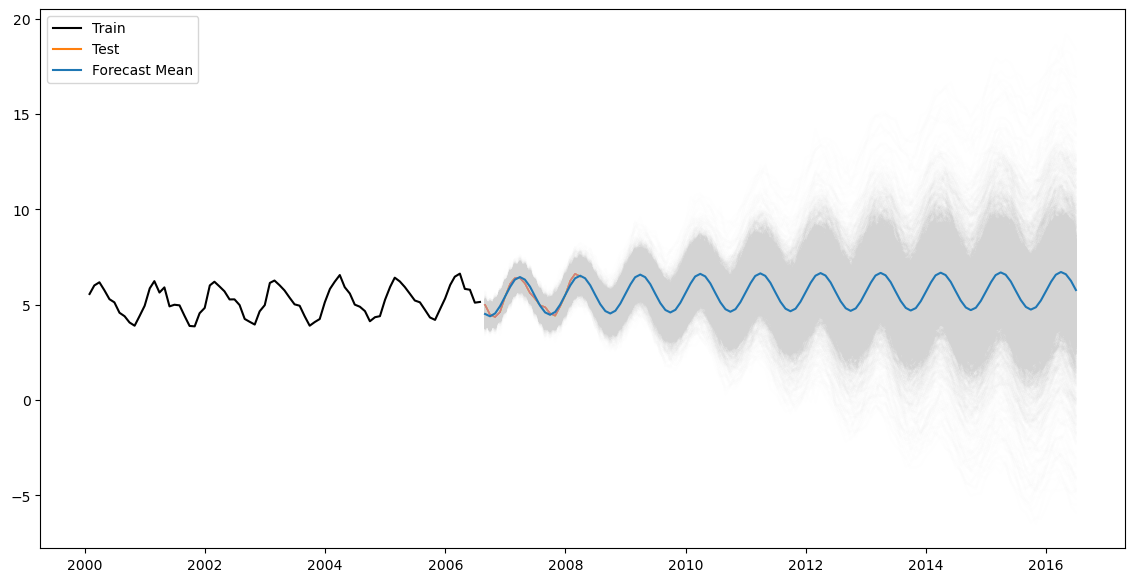

In [30]:
t_future = np.arange(len(train_df)+1, len(df)+100)
posterior = trace.posterior

# Calculate the expected value for the forecast
# Expand dimensions to broadcast properly
sigma_samples = posterior['sigma'].values.flatten()[:, np.newaxis]
intercept_samples = posterior['intercept'].values.flatten()[:, np.newaxis]
slope_samples = posterior['slope'].values.flatten()[:, np.newaxis]

amplitude_1_samples = posterior['amplitude_1'].values.flatten()[:, np.newaxis]
frequency_1_samples = posterior['frequency_1'].values.flatten()[:, np.newaxis]
phase_1_samples = posterior['phase_1'].values.flatten()[:, np.newaxis]

amplitude_2_samples = posterior['amplitude_2'].values.flatten()[:, np.newaxis]
frequency_2_samples = posterior['frequency_2'].values.flatten()[:, np.newaxis]
phase_2_samples = posterior['phase_2'].values.flatten()[:, np.newaxis]

# Compute the mean forecast
mu_forecast = (intercept_samples +
               slope_samples * t_future +
               amplitude_1_samples * np.sin(2 * np.pi * frequency_1_samples * t_future + phase_1_samples) + 
               amplitude_2_samples * np.sin(2 * np.pi * frequency_2_samples * t_future + phase_2_samples))

# Sample noise for the forecast
y_forecast = mu_forecast + np.random.normal(0, sigma_samples, size=mu_forecast.shape)

plt.figure(figsize=(14, 7))
plt.plot(train_df, label='Train', color='black')
plt.plot(test_df, label='Test', color='tab:orange')
plt.plot(pd.date_range(start=test_df.index[0], periods=len(t_future), freq='ME'), y_forecast.T, color='lightgrey', alpha=0.01)
plt.plot(pd.date_range(start=test_df.index[0], periods=len(t_future), freq='ME'), mu_forecast.mean(axis=0), color='tab:blue', label='Forecast Mean')
plt.legend()
plt.show()